Dataset umum

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau, f_oneway
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from shapely.geometry import Point
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

In [26]:
# === 1. Load & Preprocessing ===
df = pd.read_csv("seismic_gap_clean.csv")
df = df.dropna(subset=['mag', 'depth', 'latitude', 'longitude'])
df = df[(df['mag'] > 0) & (df['depth'] > 0)]

# Tambah zona kedalaman
def depth_category(depth):
    if depth < 70:
        return 'Dangkal'
    elif 70 <= depth <= 300:
        return 'Menengah'
    else:
        return 'Dalam'
df['depth_zone'] = df['depth'].apply(depth_category)

# Tambah kategori magnitudo (opsional)
def mag_category(mag):
    if mag < 4:
        return 'Minor'
    elif mag < 5:
        return 'Light'
    elif mag < 6:
        return 'Moderate'
    elif mag < 7:
        return 'Strong'
    elif mag < 8:
        return 'Major'
    else:
        return 'Great'
df['mag_cat'] = df['mag'].apply(mag_category)

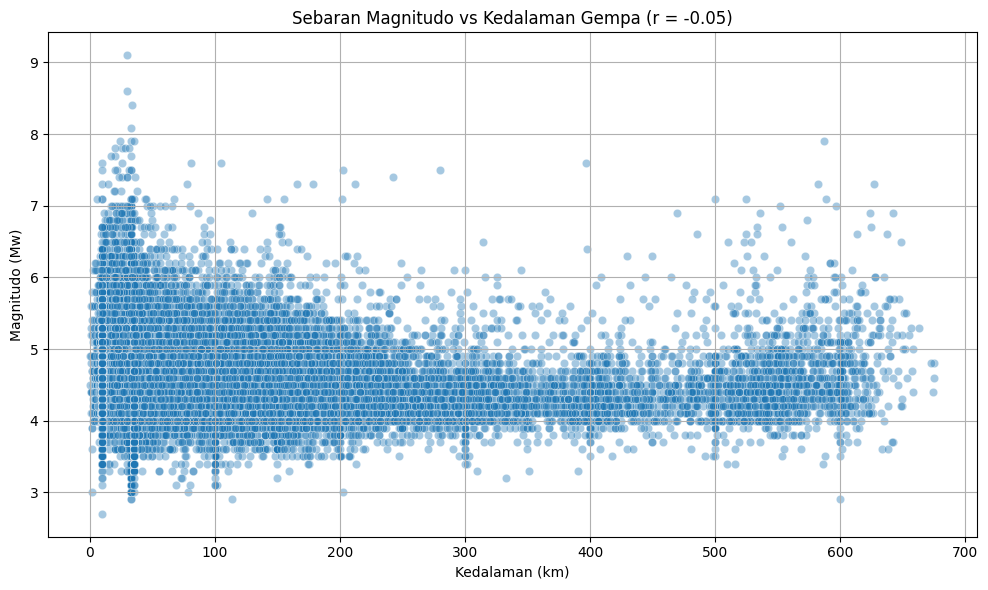

In [27]:
# === 2. Scatter Plot + Korelasi ===
plt.figure(figsize=(10, 6))
sns.scatterplot(x='depth', y='mag', data=df, alpha=0.4)
r, _ = pearsonr(df['depth'], df['mag'])
plt.title(f"Sebaran Magnitudo vs Kedalaman Gempa (r = {r:.2f})")
plt.xlabel("Kedalaman (km)")
plt.ylabel("Magnitudo (Mw)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# === 3. Korelasi Statistik ===
pearson_corr, _ = pearsonr(df['depth'], df['mag'])
spearman_corr, _ = spearmanr(df['depth'], df['mag'])
kendall_corr, _ = kendalltau(df['depth'], df['mag'])

print(f"📊 Korelasi: Pearson = {pearson_corr:.4f}, Spearman = {spearman_corr:.4f}, Kendall = {kendall_corr:.4f}")


📊 Korelasi: Pearson = -0.0472, Spearman = -0.0684, Kendall = -0.0480


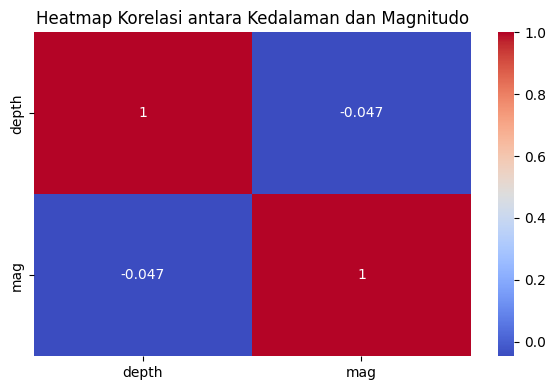

In [29]:
# === 4. Heatmap Korelasi ===
plt.figure(figsize=(6, 4))
sns.heatmap(df[['depth', 'mag']].corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi antara Kedalaman dan Magnitudo")
plt.tight_layout()
plt.show()

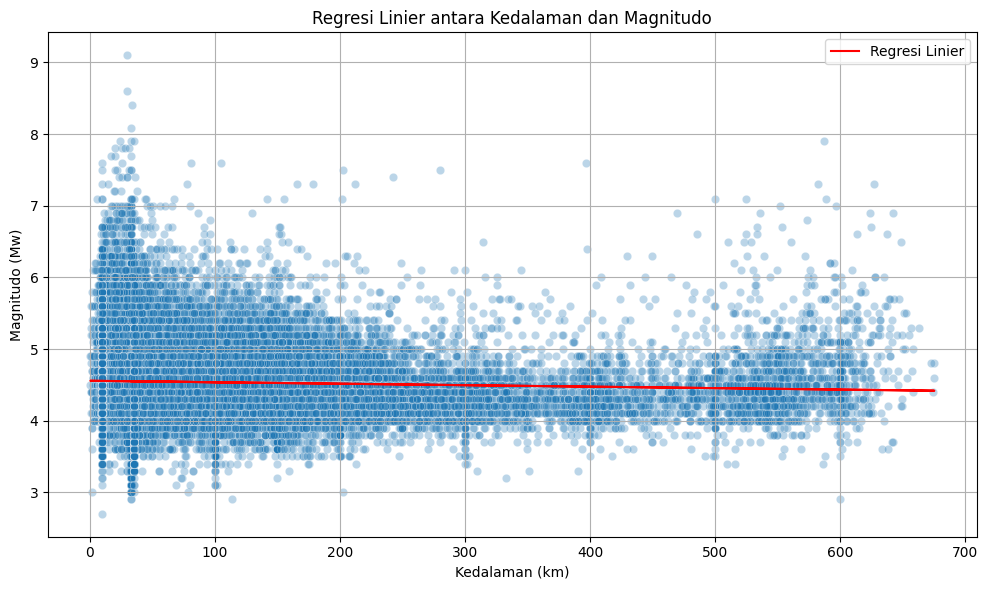

In [30]:
# === 5. Regresi Linear ===
X = df[['depth']]
y = df['mag']
model = LinearRegression().fit(X, y)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='depth', y='mag', data=df, alpha=0.3)
plt.plot(df['depth'], model.predict(X), color='red', label='Regresi Linier')
plt.xlabel("Kedalaman (km)")
plt.ylabel("Magnitudo (Mw)")
plt.title("Regresi Linier antara Kedalaman dan Magnitudo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

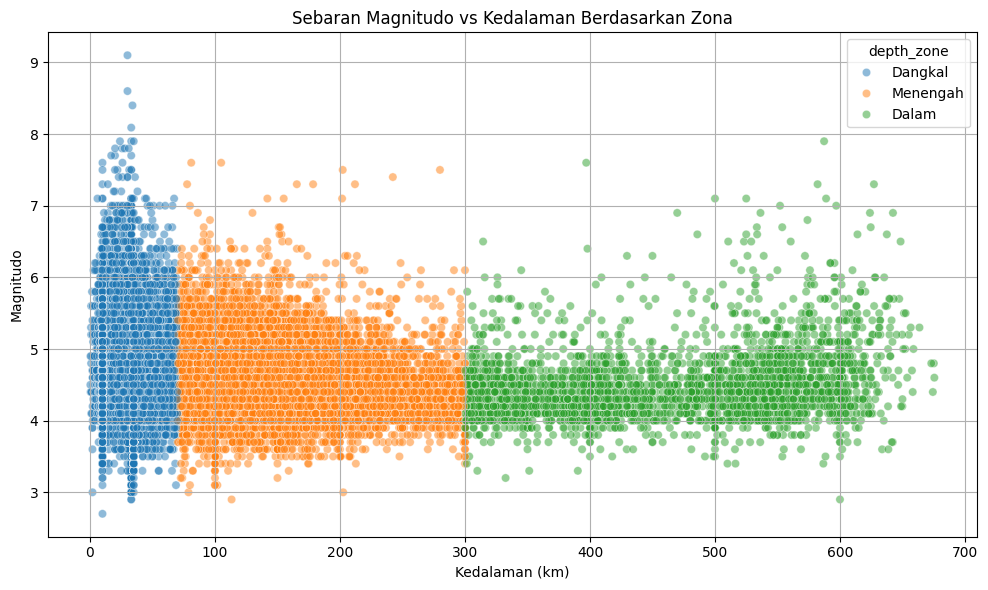

In [31]:
# === 6. Scatter Berdasarkan Zona ===
plt.figure(figsize=(10, 6))
sns.scatterplot(x='depth', y='mag', hue='depth_zone', data=df, alpha=0.5)
plt.title("Sebaran Magnitudo vs Kedalaman Berdasarkan Zona")
plt.xlabel("Kedalaman (km)")
plt.ylabel("Magnitudo")
plt.grid(True)
plt.tight_layout()
plt.show()

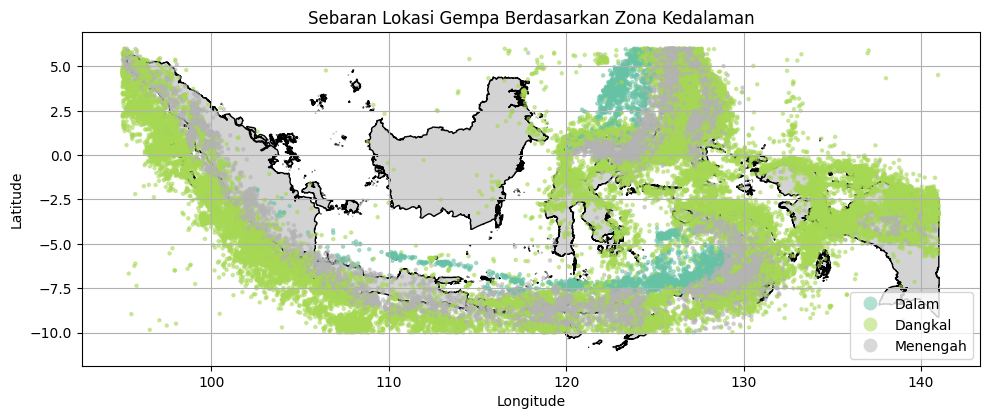

In [32]:
# === 7. Visualisasi GeoPandas ===
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
indonesia = gpd.read_file('gadm41_IDN_shp/gadm41_IDN_0.shp')

fig, ax = plt.subplots(figsize=(10, 7))
indonesia.plot(ax=ax, color='lightgray', edgecolor='black')
gdf.plot(ax=ax, column='depth_zone', markersize=5, legend=True, alpha=0.5, cmap='Set2')
plt.title("Sebaran Lokasi Gempa Berdasarkan Zona Kedalaman")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# === 8. Korelasi Per Zona ===
for zone in ['Dangkal', 'Menengah', 'Dalam']:
    subset = df[df['depth_zone'] == zone]
    p, _ = pearsonr(subset['depth'], subset['mag'])
    s, _ = spearmanr(subset['depth'], subset['mag'])
    print(f"Zona {zone}: Pearson = {p:.3f}, Spearman = {s:.3f}")

Zona Dangkal: Pearson = 0.005, Spearman = -0.006
Zona Menengah: Pearson = -0.100, Spearman = -0.108
Zona Dalam: Pearson = 0.225, Spearman = 0.221


C:\Users\fmoch\AppData\Local\Temp\ipykernel_1012\4213508786.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='depth_zone', y='mag', data=df, palette='Set2')


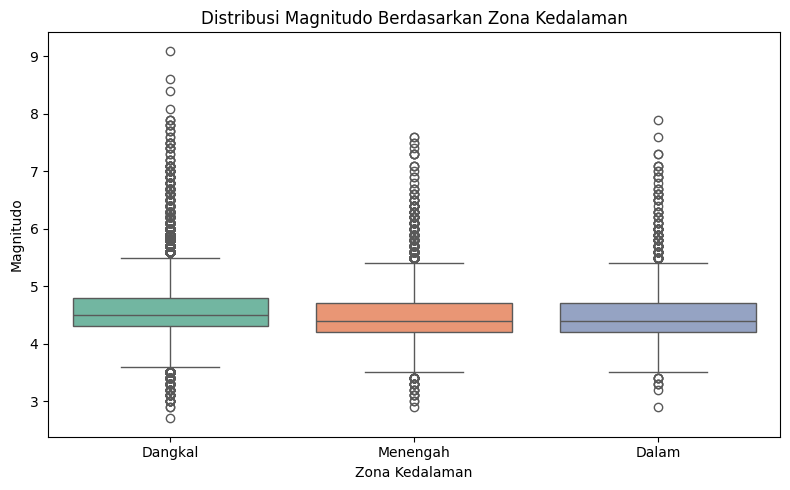

In [34]:
# === 9. Boxplot Per Zona ===
plt.figure(figsize=(8, 5))
sns.boxplot(x='depth_zone', y='mag', data=df, palette='Set2')
plt.title("Distribusi Magnitudo Berdasarkan Zona Kedalaman")
plt.xlabel("Zona Kedalaman")
plt.ylabel("Magnitudo")
plt.tight_layout()
plt.show()


In [35]:
# === 10. Uji ANOVA & Tukey ===
group_dangkal = df[df['depth_zone'] == 'Dangkal']['mag']
group_menengah = df[df['depth_zone'] == 'Menengah']['mag']
group_dalam = df[df['depth_zone'] == 'Dalam']['mag']
f_stat, p_value = f_oneway(group_dangkal, group_menengah, group_dalam)
print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("➡️ Perbedaan rata-rata magnitudo antar zona signifikan.")
else:
    print("➡️ Tidak ada perbedaan signifikan antara zona.")

F-statistic: 123.5658, P-value: 0.0000
➡️ Perbedaan rata-rata magnitudo antar zona signifikan.


In [36]:
# Tukey post-hoc test
tukey = pairwise_tukeyhsd(df['mag'], df['depth_zone'])
print(tukey.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------
  Dalam  Dangkal   0.0689    0.0  0.0491  0.0888   True
  Dalam Menengah   0.0113 0.4037 -0.0093   0.032  False
Dangkal Menengah  -0.0576    0.0 -0.0669 -0.0483   True
-------------------------------------------------------


Dataset Clustering

In [37]:
# === 1. Import Library ===
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression   

In [38]:
# === 2. Load Dataset Clustering ===
df = pd.read_csv("hasil_clustering_gempa.csv")

# Filter data yang valid
df = df.dropna(subset=['mag', 'depth', 'cluster'])
df = df[(df['mag'] > 0) & (df['depth'] > 0)]

# Pastikan cluster berupa integer
df['cluster'] = df['cluster'].astype(int)

In [39]:
# === 3. Analisis Korelasi Per Cluster ===
print("📊 Korelasi Magnitudo dan Kedalaman per Cluster:\n")
for cluster_id in sorted(df['cluster'].unique()):
    sub = df[df['cluster'] == cluster_id]
    pearson_corr, _ = pearsonr(sub['depth'], sub['mag'])
    spearman_corr, _ = spearmanr(sub['depth'], sub['mag'])
    print(f"🔹 Cluster {cluster_id}: Pearson = {pearson_corr:.3f}, Spearman = {spearman_corr:.3f}")


📊 Korelasi Magnitudo dan Kedalaman per Cluster:

🔹 Cluster 0: Pearson = -0.054, Spearman = -0.060
🔹 Cluster 1: Pearson = 0.255, Spearman = 0.206
🔹 Cluster 2: Pearson = -0.025, Spearman = -0.039


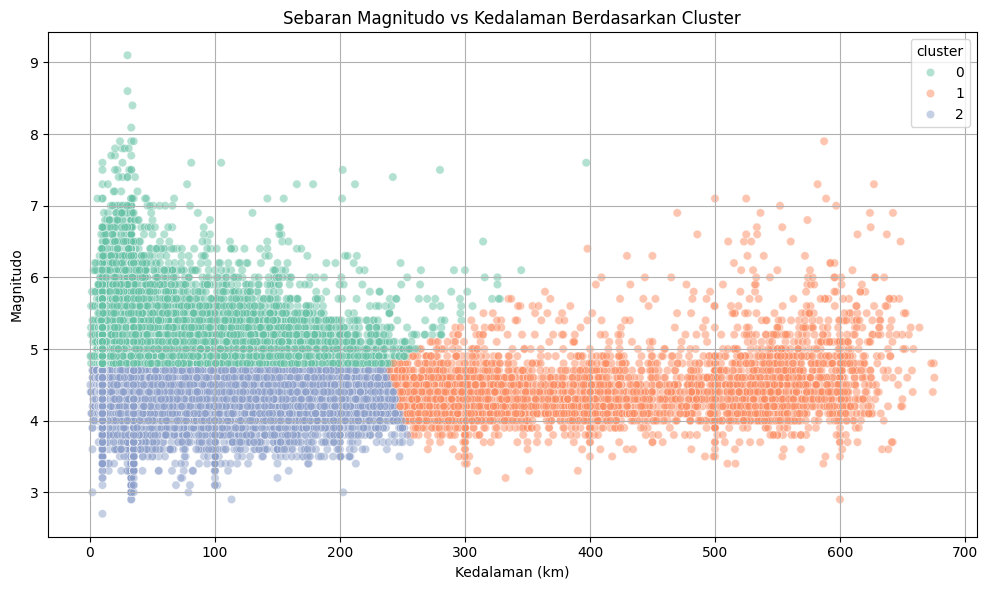

In [40]:
# === 4. Scatterplot Magnitudo vs Kedalaman per Cluster ===
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='depth', y='mag', hue='cluster', palette='Set2', alpha=0.5)
plt.title("Sebaran Magnitudo vs Kedalaman Berdasarkan Cluster")
plt.xlabel("Kedalaman (km)")
plt.ylabel("Magnitudo")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\fmoch\AppData\Local\Temp\ipykernel_1012\4286767651.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='mag', palette='Set2')


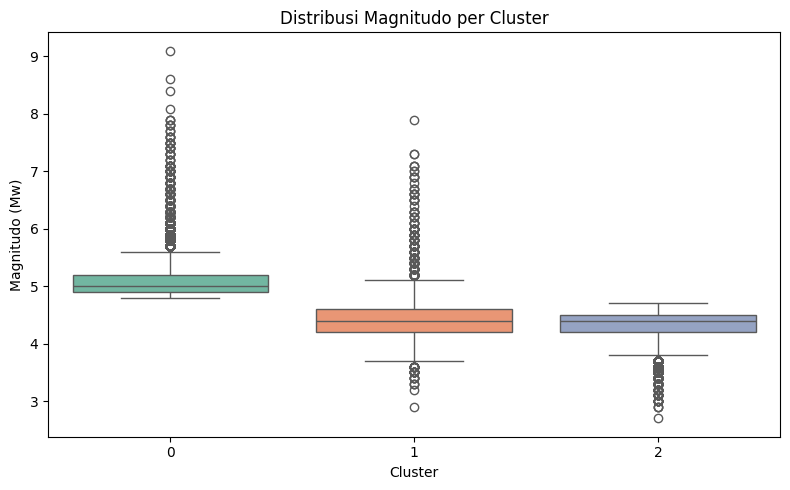

In [41]:
# === 5. Boxplot Magnitudo per Cluster ===
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='cluster', y='mag', palette='Set2')
plt.title("Distribusi Magnitudo per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Magnitudo (Mw)")
plt.tight_layout()
plt.show()

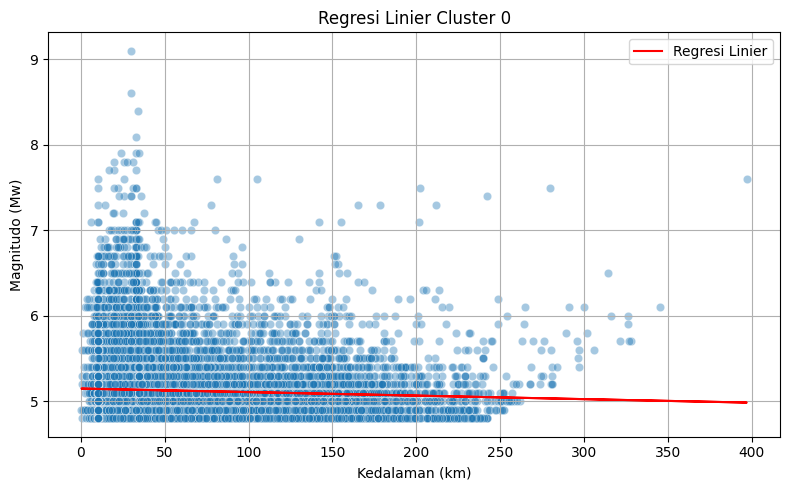

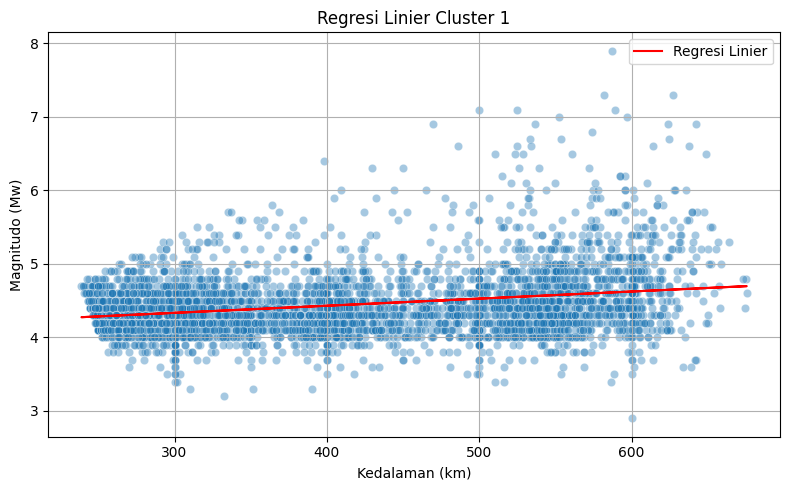

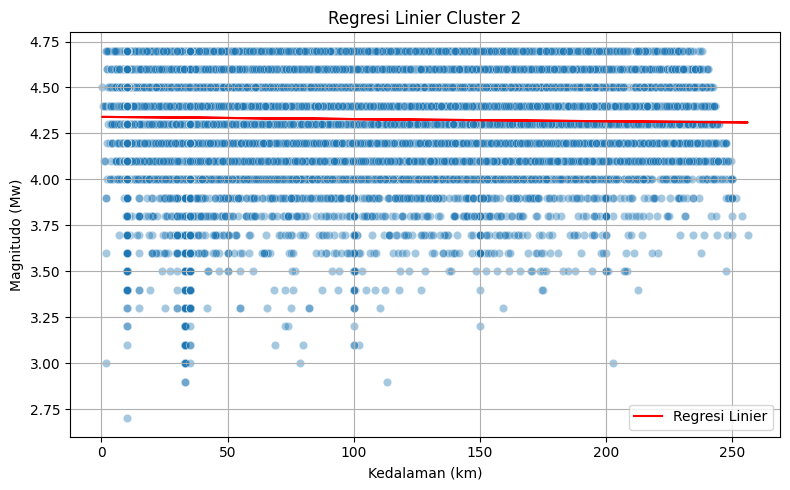

In [42]:
# === 6. Regresi Linier per Cluster (Opsional Tambahan) ===
for cluster_id in sorted(df['cluster'].unique()):
    subset = df[df['cluster'] == cluster_id]
    X = subset[['depth']]
    y = subset['mag']
    model = LinearRegression().fit(X, y)
    
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='depth', y='mag', data=subset, alpha=0.4)
    plt.plot(subset['depth'], model.predict(X), color='red', label='Regresi Linier')
    plt.title(f"Regresi Linier Cluster {cluster_id}")
    plt.xlabel("Kedalaman (km)")
    plt.ylabel("Magnitudo (Mw)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [43]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# === 1. Siapkan data per cluster ===
cluster_groups = [df[df['cluster'] == c]['mag'] for c in sorted(df['cluster'].unique())]

# === 2. Uji ANOVA ===
f_stat, p_value = f_oneway(*cluster_groups)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("✅ Terdapat perbedaan signifikan rata-rata magnitudo antar cluster.")
else:
    print("ℹ️ Tidak ada perbedaan signifikan antar cluster.")

# === 3. Uji Lanjutan: Tukey HSD ===
tukey = pairwise_tukeyhsd(df['mag'], df['cluster'])
print("\nHasil Tukey HSD:")
print(tukey.summary())


F-statistic: 39256.7725
P-value: 0.0000
✅ Terdapat perbedaan signifikan rata-rata magnitudo antar cluster.

Hasil Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.6685   0.0 -0.6813 -0.6558   True
     0      2  -0.7913   0.0  -0.798 -0.7847   True
     1      2  -0.1228   0.0 -0.1347 -0.1109   True
---------------------------------------------------


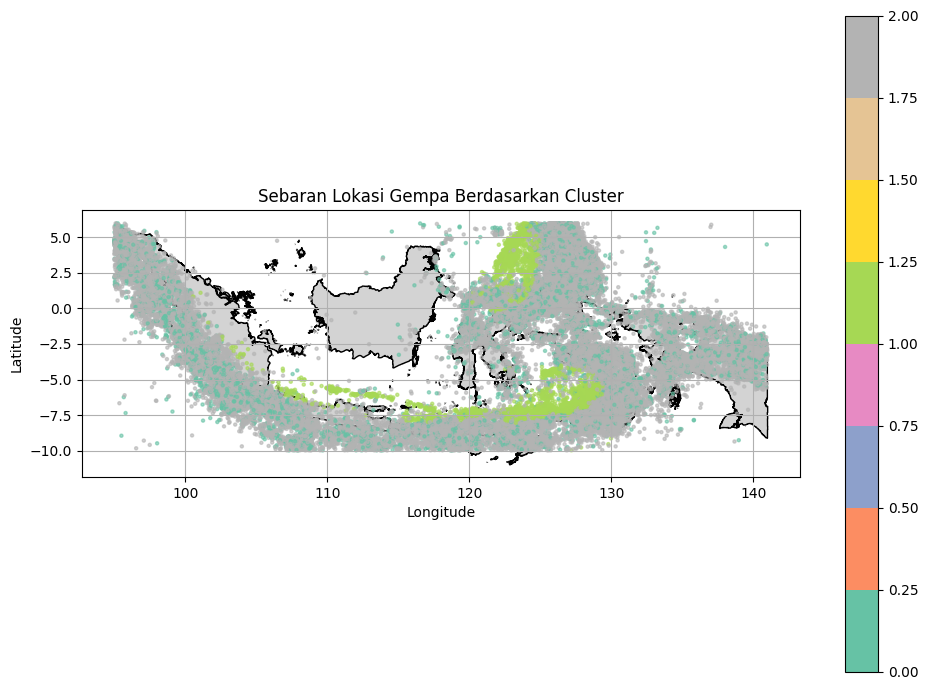

In [44]:
import geopandas as gpd
from shapely.geometry import Point

# === 1. Pastikan data koordinat valid ===
df = df.dropna(subset=['latitude', 'longitude'])
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# === 2. Load shapefile Indonesia (pastikan sudah ada) ===
indo = gpd.read_file('gadm41_IDN_shp/gadm41_IDN_0.shp')

# === 3. Plot ===
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
indo.plot(ax=ax, color='lightgray', edgecolor='black')
gdf.plot(ax=ax, column='cluster', cmap='Set2', legend=True, markersize=5, alpha=0.6)
plt.title("Sebaran Lokasi Gempa Berdasarkan Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()
